# **Import necessary packages**

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, GlobalAveragePooling2D, Dense, 
                                     Dropout, BatchNormalization, GaussianNoise)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# **Configuration**

In [2]:
BASE_DIR = '/kaggle/input/chest-xray-pneumonia/chest_xray'
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 0.0001

# **Data Preparation**

In [3]:
def load_data(base_dir):
    categories = {'NORMAL': 'NORMAL', 'PNEUMONIA': 'PNEUMONIA'}
    file_paths, labels = [], []
    
    for label, subfolder in categories.items():
        folder_path = os.path.join(base_dir, 'train', subfolder)
        for filename in os.listdir(folder_path):
            if filename.lower().endswith(('png', 'jpg', 'jpeg')):
                file_paths.append(os.path.join(folder_path, filename))
                labels.append(label)
    
    return pd.DataFrame({'file_path': file_paths, 'label': labels})

df = load_data(BASE_DIR)

# **Data Balancing**

In [4]:
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(df[['file_path']], df['label'])
df_resampled = pd.DataFrame(X_resampled, columns=['file_path'])
df_resampled['label'] = y_resampled

# **Encoding Labels**

In [5]:
le = LabelEncoder()
df_resampled['label_encoded'] = le.fit_transform(df_resampled['label'])

# **Train-Test Split**

In [6]:
train_df, temp_df = train_test_split(df_resampled, train_size=0.8, stratify=df_resampled['label_encoded'])
valid_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label_encoded'])

# **Image Generators**

In [7]:
def create_generators(train, valid, test, img_size, batch_size):
    train_gen = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
        train, x_col='file_path', y_col='label_encoded', target_size=img_size, 
        class_mode='categorical', batch_size=batch_size, shuffle=True
    )
    valid_gen = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
        valid, x_col='file_path', y_col='label_encoded', target_size=img_size, 
        class_mode='categorical', batch_size=batch_size, shuffle=True
    )
    test_gen = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
        test, x_col='file_path', y_col='label_encoded', target_size=img_size, 
        class_mode='categorical', batch_size=batch_size, shuffle=False
    )
    return train_gen, valid_gen, test_gen


In [8]:
train_df, temp_df = train_test_split(df_resampled, train_size=0.8, stratify=df_resampled['label_encoded'])
valid_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label_encoded'])

train_df['label_encoded'] = train_df['label_encoded'].astype(str)
valid_df['label_encoded'] = valid_df['label_encoded'].astype(str)
test_df['label_encoded'] = test_df['label_encoded'].astype(str)

train_gen, valid_gen, test_gen = create_generators(train_df, valid_df, test_df, IMG_SIZE, BATCH_SIZE)


Found 6200 validated image filenames belonging to 2 classes.
Found 775 validated image filenames belonging to 2 classes.
Found 775 validated image filenames belonging to 2 classes.


# **Model Definition**

In [9]:
def create_model(input_shape, learning_rate):
    inputs = Input(shape=input_shape)
    base_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_tensor=inputs)
    for layer in base_model.layers:
        layer.trainable = False
    
    x = GlobalAveragePooling2D()(base_model.output)
    x = GaussianNoise(0.1)(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(2, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [10]:
model = create_model((*IMG_SIZE, 3), LEARNING_RATE)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# **Callbacks**

In [11]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# **Training**

In [12]:
history = model.fit(train_gen, validation_data=valid_gen, epochs=EPOCHS, callbacks=[early_stopping])

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


194/194 ━━━━━━━━━━━━━━━━━━━━ 153s 665ms/step - accuracy: 0.8441 - loss: 0.3727 - val_accuracy: 0.9548 - val_loss: 0.1179
Epoch 2/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 84s 421ms/step - accuracy: 0.9313 - loss: 0.1737 - val_accuracy: 0.9703 - val_loss: 0.0990
Epoch 3/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 83s 416ms/step - accuracy: 0.9479 - loss: 0.1379 - val_accuracy: 0.9755 - val_loss: 0.0875
Epoch 4/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 83s 415ms/step - accuracy: 0.9574 - loss: 0.1173 - val_accuracy: 0.9806 - val_loss: 0.0782
Epoch 5/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 83s 416ms/step - accuracy: 0.9591 - loss: 0.1151 - val_accuracy: 0.9768 - val_loss: 0.0755
Epoch 6/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 82s 409ms/step - accuracy: 0.9653 - loss: 0.1028 - val_accuracy: 0.9755 - val_loss: 0.0666
Epoch 7/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 83s 413ms/step - accuracy: 0.9598 - loss: 0.1055 - val_accuracy: 0.9832 - val_loss: 0.0670
Epoch 8/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 84s 417ms/step - accuracy: 0.9624 - loss: 0.1064 - va

# **Evaluation**

In [13]:
y_true = test_gen.labels
y_pred = np.argmax(model.predict(test_gen), axis=1)

25/25 ━━━━━━━━━━━━━━━━━━━━ 19s 598ms/step


# **Confusion Matrix and Classification Report**

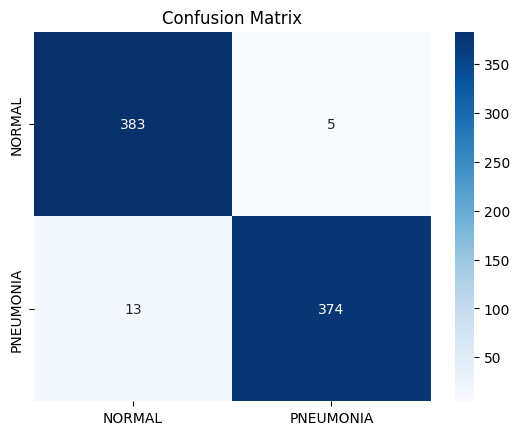

Classification Report:
               precision    recall  f1-score   support

      NORMAL       0.97      0.99      0.98       388
   PNEUMONIA       0.99      0.97      0.98       387

    accuracy                           0.98       775
   macro avg       0.98      0.98      0.98       775
weighted avg       0.98      0.98      0.98       775



In [14]:
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.show()

report = classification_report(y_true, y_pred, target_names=le.classes_)
print("Classification Report:\n", report)

# **Plot Training Curves**

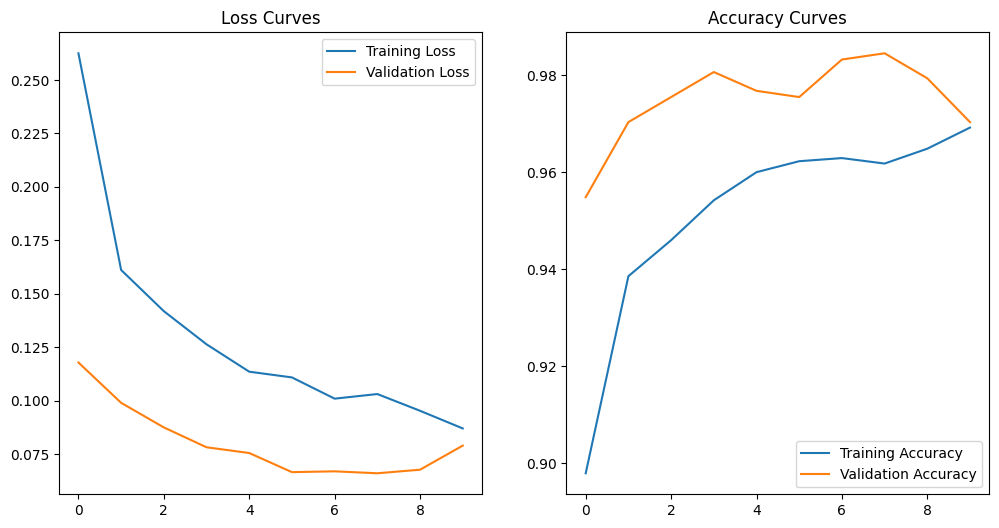

In [15]:
def plot_training_curves(history):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title("Loss Curves")
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title("Accuracy Curves")
    plt.show()

plot_training_curves(history)

In [16]:
model.save("model.h5")
print("Model saved as model.h5")

Model saved as model.h5
